## Step 1: Install & Import Required Libraries

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from datetime import datetime
import matplotlib.dates as mdates


# Set plotting style
sns.set(style='whitegrid')

## Step 2: Define Tickers and Download Historical Data

In [ ]:
# Tickers of U.S. energy sector stocks
tickers = [
    "XOM", "CVX", "SHEL", "TTFNF", "TTE", "COP", "WMB", "EOG", "LNG", "OKE",
    "PSX", "MPC", "HES", "FANG", "TRGP", "VLO", "IMO", "TPL", "CQP", "EXE",
    "DTM", "SUN", "NFG", "DCCPF", "GZPZF", "CHRD", "LB", "DLKGF", "GPOR",
    "TRRVF", "NRP", "LEU", "SBR", "PNRG", "FGPRB", "PDER", "AMEN", "RSRV",
    "TRKX", "LCNTU", "VIRDY", "CNR", "EXEEL", "EXEEZ", "PZZPF", "TTYP"
]

# Download data (adjusted close prices)
start_date = "2010-01-01"
end_date = datetime.today().strftime('%Y-%m-%d')

stocks = yf.download(tickers, start=start_date, end=end_date)['Close']
stocks = stocks.dropna(axis=1, how='all')  # Drop tickers with no data
#data = data.dropna()  # Drop rows with missing values

# Drop any tickers with  missing data
threshold = int(1.0 * len(stocks))  # keep only tickers with at least 50% non-null values
data = stocks.dropna(axis=1, thresh=threshold)

# Forward-fill and back-fill remaining missing values
# data = data.ffill().bfill()

# Show summary
print("Downloaded data shape:", data.shape)
print("Remaining tickers after filtering:", data.columns.tolist())

# Preview the data
data.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  46 of 46 completed


Downloaded data shape: (3846, 24)
Remaining tickers after filtering: ['AMEN', 'COP', 'CQP', 'CVX', 'EOG', 'HES', 'IMO', 'LEU', 'LNG', 'NFG', 'NRP', 'OKE', 'PDER', 'PNRG', 'RSRV', 'SBR', 'SHEL', 'TPL', 'TTE', 'TTYP', 'VIRDY', 'VLO', 'WMB', 'XOM']


Ticker,AMEN,COP,CQP,CVX,EOG,HES,IMO,LEU,LNG,NFG,...,RSRV,SBR,SHEL,TPL,TTE,TTYP,VIRDY,VLO,WMB,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,95.984467,23.572039,4.742822,43.122459,36.268795,51.095257,30.250935,1140.109863,2.402445,31.863392,...,190.014465,12.490979,28.374710,8.410582,26.807283,7.263495,41279.691406,9.982554,8.169250,38.923954
2010-01-05,95.984467,23.594452,4.922263,43.427914,35.824398,51.410770,30.442646,1134.615356,2.441037,32.045788,...,180.352707,12.624044,28.406559,8.886978,26.868330,7.263495,42157.984375,10.239235,8.271317,39.075939
2010-01-06,95.984467,23.764811,5.055961,43.433365,35.943638,51.548283,30.588343,1173.076904,2.662950,32.114986,...,180.352707,12.748054,28.174467,8.661771,26.860189,7.263495,42908.187500,10.495908,8.539719,39.413666
2010-01-07,95.984467,23.670662,5.316324,43.269726,35.607609,52.535244,30.059229,1203.296753,2.826972,31.926291,...,180.352707,12.941623,28.037947,8.589591,26.799147,7.526937,44591.582031,10.574029,8.479238,39.289829
2010-01-08,95.984467,23.876881,5.136884,43.346111,35.788273,53.255238,30.296947,1181.318726,3.039237,32.133850,...,180.352707,13.059571,27.996992,8.373048,26.961922,7.526937,45872.425781,10.428951,8.547283,39.132221


## Step 3: Calculate Daily Returns

In [ ]:
returns = data.pct_change().dropna()
returns.head()

Ticker,AMEN,COP,CQP,CVX,EOG,HES,IMO,LEU,LNG,NFG,...,RSRV,SBR,SHEL,TPL,TTE,TTYP,VIRDY,VLO,WMB,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,0.0,0.000951,0.037834,0.007083,-0.012253,0.006175,0.006337,-0.004819,0.016064,0.005724,...,-0.050847,0.010653,0.001122,0.056643,0.002277,0.000000,0.021277,0.025713,0.012494,0.003905
2010-01-06,0.0,0.007220,0.027162,0.000126,0.003328,0.002675,0.004786,0.033898,0.090909,0.002159,...,0.000000,0.009823,-0.008170,-0.025341,-0.000303,0.000000,0.017795,0.025068,0.032450,0.008643
2010-01-07,0.0,-0.003962,0.051496,-0.003768,-0.009349,0.019146,-0.017298,0.025761,0.061594,-0.005876,...,0.000000,0.015184,-0.004846,-0.008333,-0.002273,0.036269,0.039232,0.007443,-0.007082,-0.003142
2010-01-08,0.0,0.008712,-0.033753,0.001765,0.005074,0.013705,0.007908,-0.018265,0.075086,0.006501,...,0.000000,0.009114,-0.001461,-0.025210,0.006074,0.000000,0.028724,-0.013720,0.008025,-0.004011
2010-01-11,0.0,0.005821,0.032876,0.017742,-0.009188,-0.010482,0.002784,-0.006977,0.126984,0.015659,...,-0.146250,-0.005557,0.015605,-0.002759,0.014941,0.000000,0.064619,-0.009631,-0.006192,0.011220


In [ ]:
returns_monthly = data.resample('M').last().pct_change().dropna()
returns_monthly.tail()

<ipython-input-4-3486c4d5d40b>:1: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns_monthly = data.resample('M').last().pct_change().dropna()


Ticker,AMEN,COP,CQP,CVX,EOG,HES,IMO,LEU,LNG,NFG,...,RSRV,SBR,SHEL,TPL,TTE,TTYP,VIRDY,VLO,WMB,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2024-12-31,-0.022958,-0.084641,-0.088069,-0.105539,-0.080144,-0.093042,-0.166667,-0.268022,-0.040802,-0.043347,...,-0.018000,0.001986,-0.032283,-0.308122,-0.045625,0.008217,0.000000,-0.118565,-0.067159,-0.088081
2025-01-31,0.026000,-0.003428,0.155120,0.030033,0.033486,0.045260,0.081818,0.235550,0.040862,0.154087,...,0.092390,0.028256,0.051077,0.172891,0.064771,-0.042647,0.000000,0.093778,0.024205,-0.006879
2025-02-28,0.095517,0.011379,0.118239,0.075001,0.009142,0.071280,0.018007,0.102430,0.024297,0.073825,...,-0.033898,-0.005394,0.035454,0.100819,0.037911,-0.009217,0.387206,-0.017068,0.049612,0.051444
2025-03-31,0.032346,0.059203,-0.024664,0.054659,0.010241,0.076077,0.066038,-0.314339,0.012426,0.059986,...,0.011696,0.039673,0.086273,-0.071062,0.088418,0.000000,0.082969,0.010250,0.036381,0.068266
2025-04-30,-0.070175,-0.177680,-0.076166,-0.190866,-0.148231,-0.198961,-0.140487,0.047259,-0.017070,-0.005809,...,-0.131329,-0.031739,-0.126228,-0.035781,-0.106044,-0.100775,0.177419,-0.188839,-0.025100,-0.123938


## Step 4: Basic EDA

### 4.1 Summary Statistics

In [ ]:
# Summary statistics of returns
summary_stats = returns.describe().T[['mean', 'std', 'min', 'max']]
summary_stats['skew'] = returns.skew()
summary_stats['kurtosis'] = returns.kurtosis()
summary_stats.sort_values(by='mean', ascending=False).head(10)

,mean,std,min,max,skew,kurtosis
Ticker,,,,,,
VIRDY,0.016733,1.085689,-0.990000,67.253969,61.823499,3829.759062
LNG,0.001683,0.032167,-0.357657,0.686274,2.811207,65.190182
TPL,0.001649,0.026185,-0.248858,0.261400,0.329438,10.627882
AMEN,0.001466,0.045780,-0.327619,0.495727,1.551174,23.913338
LEU,0.001281,0.067446,-0.601589,1.438944,5.122283,94.406170
TTYP,0.001161,0.035871,-0.371429,0.605504,3.155338,72.444974
PNRG,0.001045,0.036082,-0.303874,0.579477,1.486172,28.659135
VLO,0.000919,0.024605,-0.192209,0.312025,0.430813,12.000414
CQP,0.000912,0.022058,-0.245628,0.160919,-0.837338,14.262022


### 4.2 Correlation Heatmap

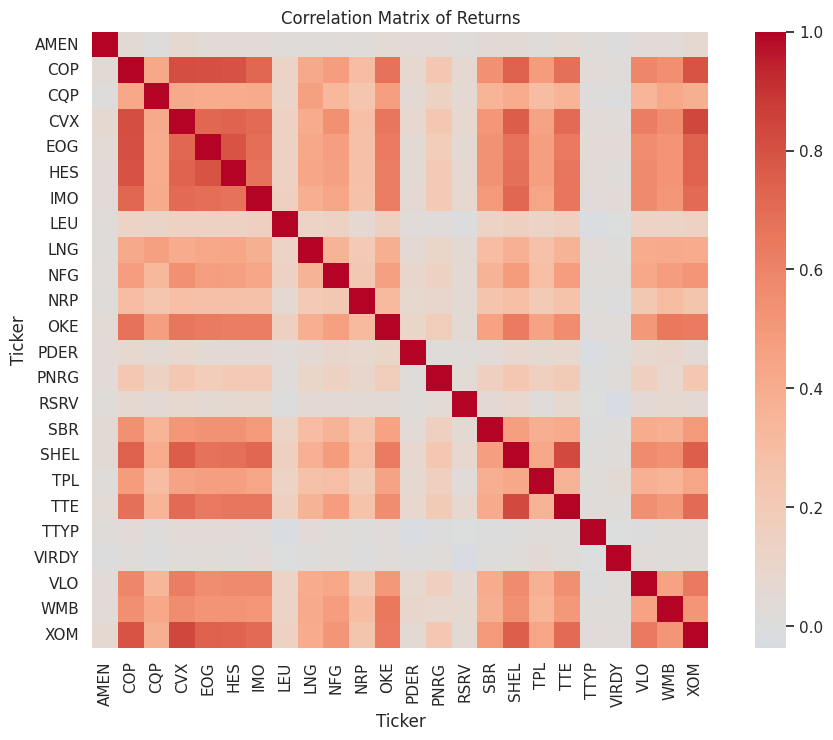

In [ ]:
plt.figure(figsize=(12, 8))
corr_matrix = returns.corr()
sns.heatmap(corr_matrix, cmap='coolwarm', center=0, square=True)
plt.title('Correlation Matrix of Returns')
plt.show()


### 4.3 Volatility Analysis

In [ ]:
volatility= returns.std()
volatility

,0
Ticker,
AMEN,0.045780
COP,0.021416
CQP,0.022058
CVX,0.016965
EOG,0.023819
HES,0.025271
IMO,0.020581
LEU,0.067446
LNG,0.032167


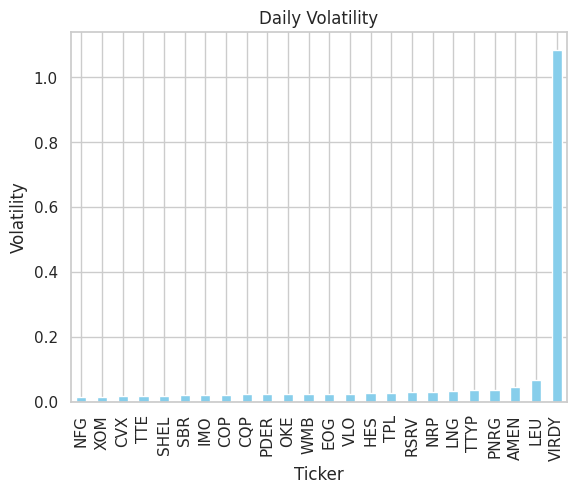

In [ ]:
volatility.sort_values().plot(kind='bar', color='skyblue', title="Daily Volatility")
plt.ylabel("Volatility")
plt.show()

<Axes: title={'center': 'Monthly Volatility'}, xlabel='Ticker'>

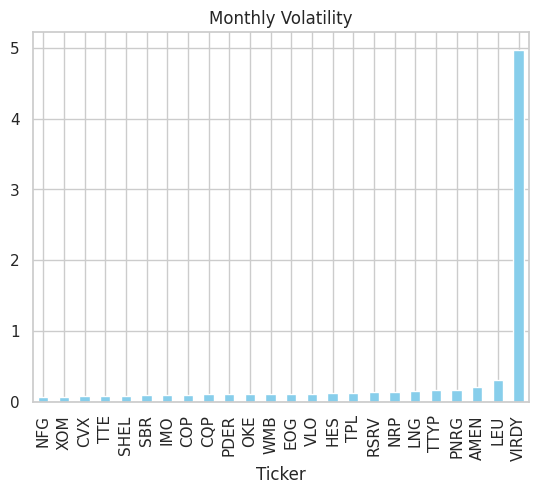

In [ ]:
volatility_month= returns.std()*np.sqrt(21)
volatility_month.sort_values().plot(kind='bar', color='skyblue', title="Monthly Volatility")

<Axes: title={'center': 'Yearly Volatility'}, xlabel='Ticker'>

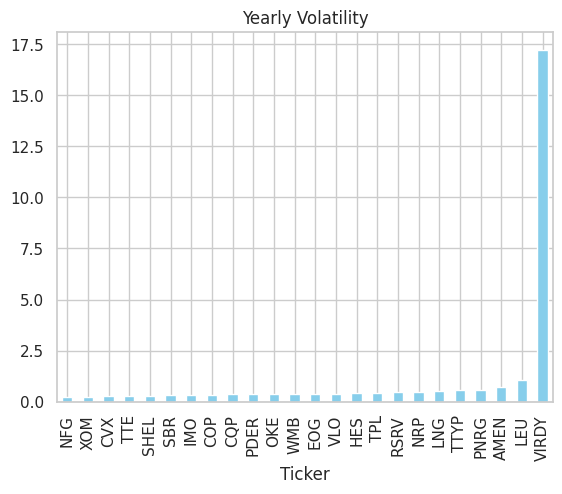

In [ ]:
volatility_annual= returns.std()*np.sqrt(252)
volatility_annual.sort_values().plot(kind='bar', color='skyblue', title="Yearly Volatility")

### 4.4 Cumulative Returns Plot

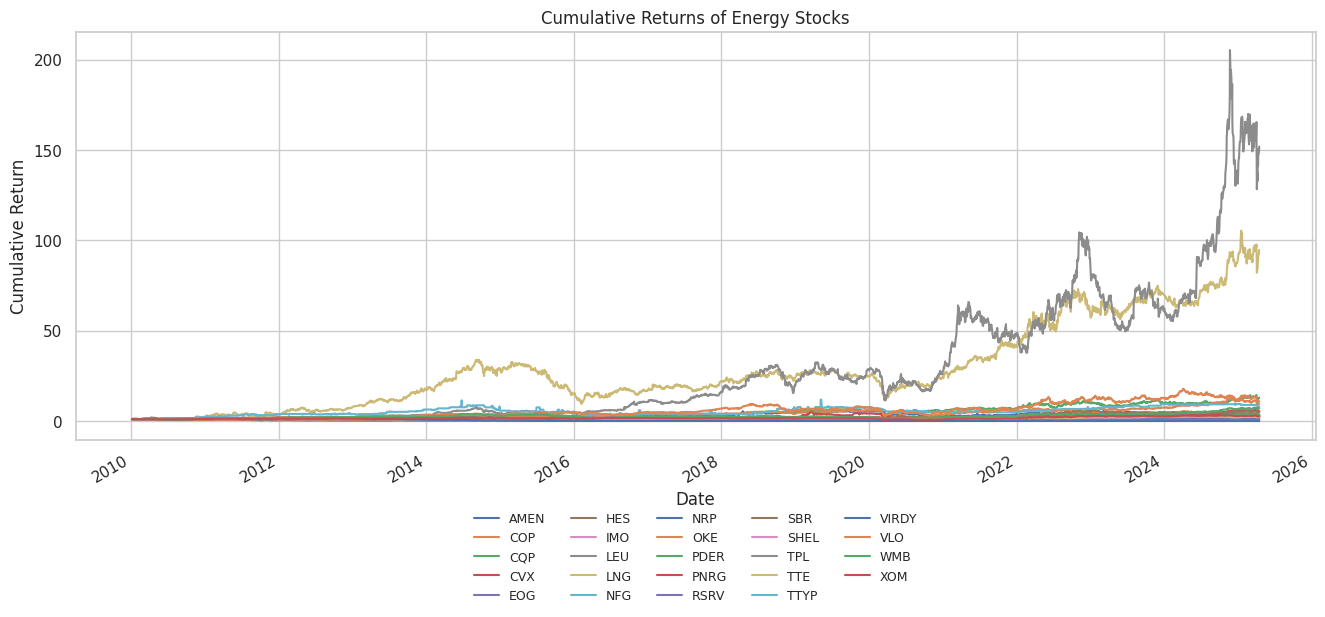

In [ ]:
cumulative_returns = (1 + returns).cumprod()
cumulative_returns.plot(figsize=(16, 6), title="Cumulative Returns of Energy Stocks")
plt.ylabel("Cumulative Return")
# Move the legend outside the plot, below it, with columns
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
           ncol=5, fontsize=9, frameon=False)

plt.show()

## 4.5 Plot of Average Returns vs Volatility

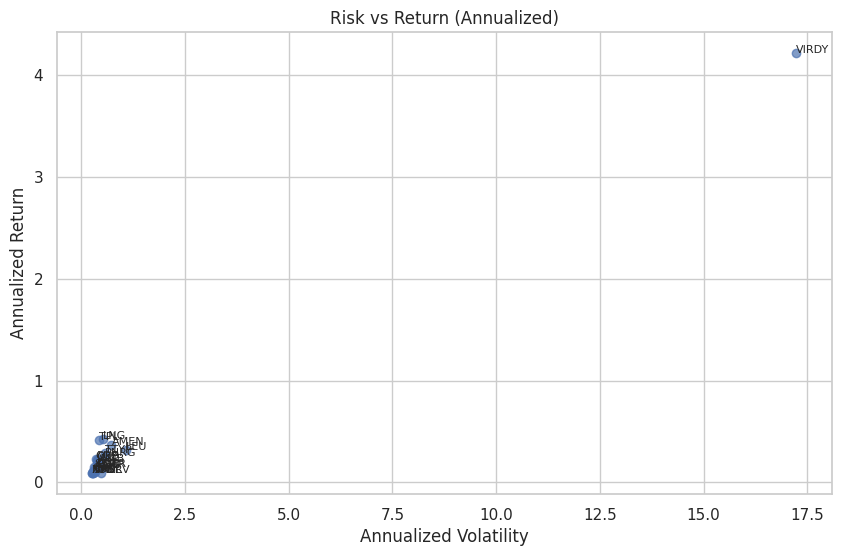

In [ ]:
avg_returns = returns.mean() * 252
volatility = returns.std() * np.sqrt(252)

plt.figure(figsize=(10, 6))
plt.scatter(volatility, avg_returns, alpha=0.7)
for ticker in returns.columns:
    plt.text(volatility[ticker], avg_returns[ticker], ticker, fontsize=8)
plt.xlabel('Annualized Volatility')
plt.ylabel('Annualized Return')
plt.title('Risk vs Return (Annualized)')
plt.grid(True)
plt.show()

<Axes: title={'center': 'Yearly Return'}, xlabel='Ticker'>

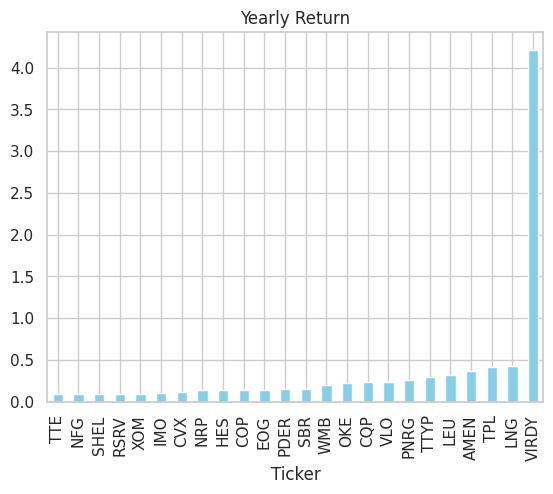

In [ ]:
avg_returns.sort_values().plot(kind='bar', color='skyblue', title="Yearly Return")

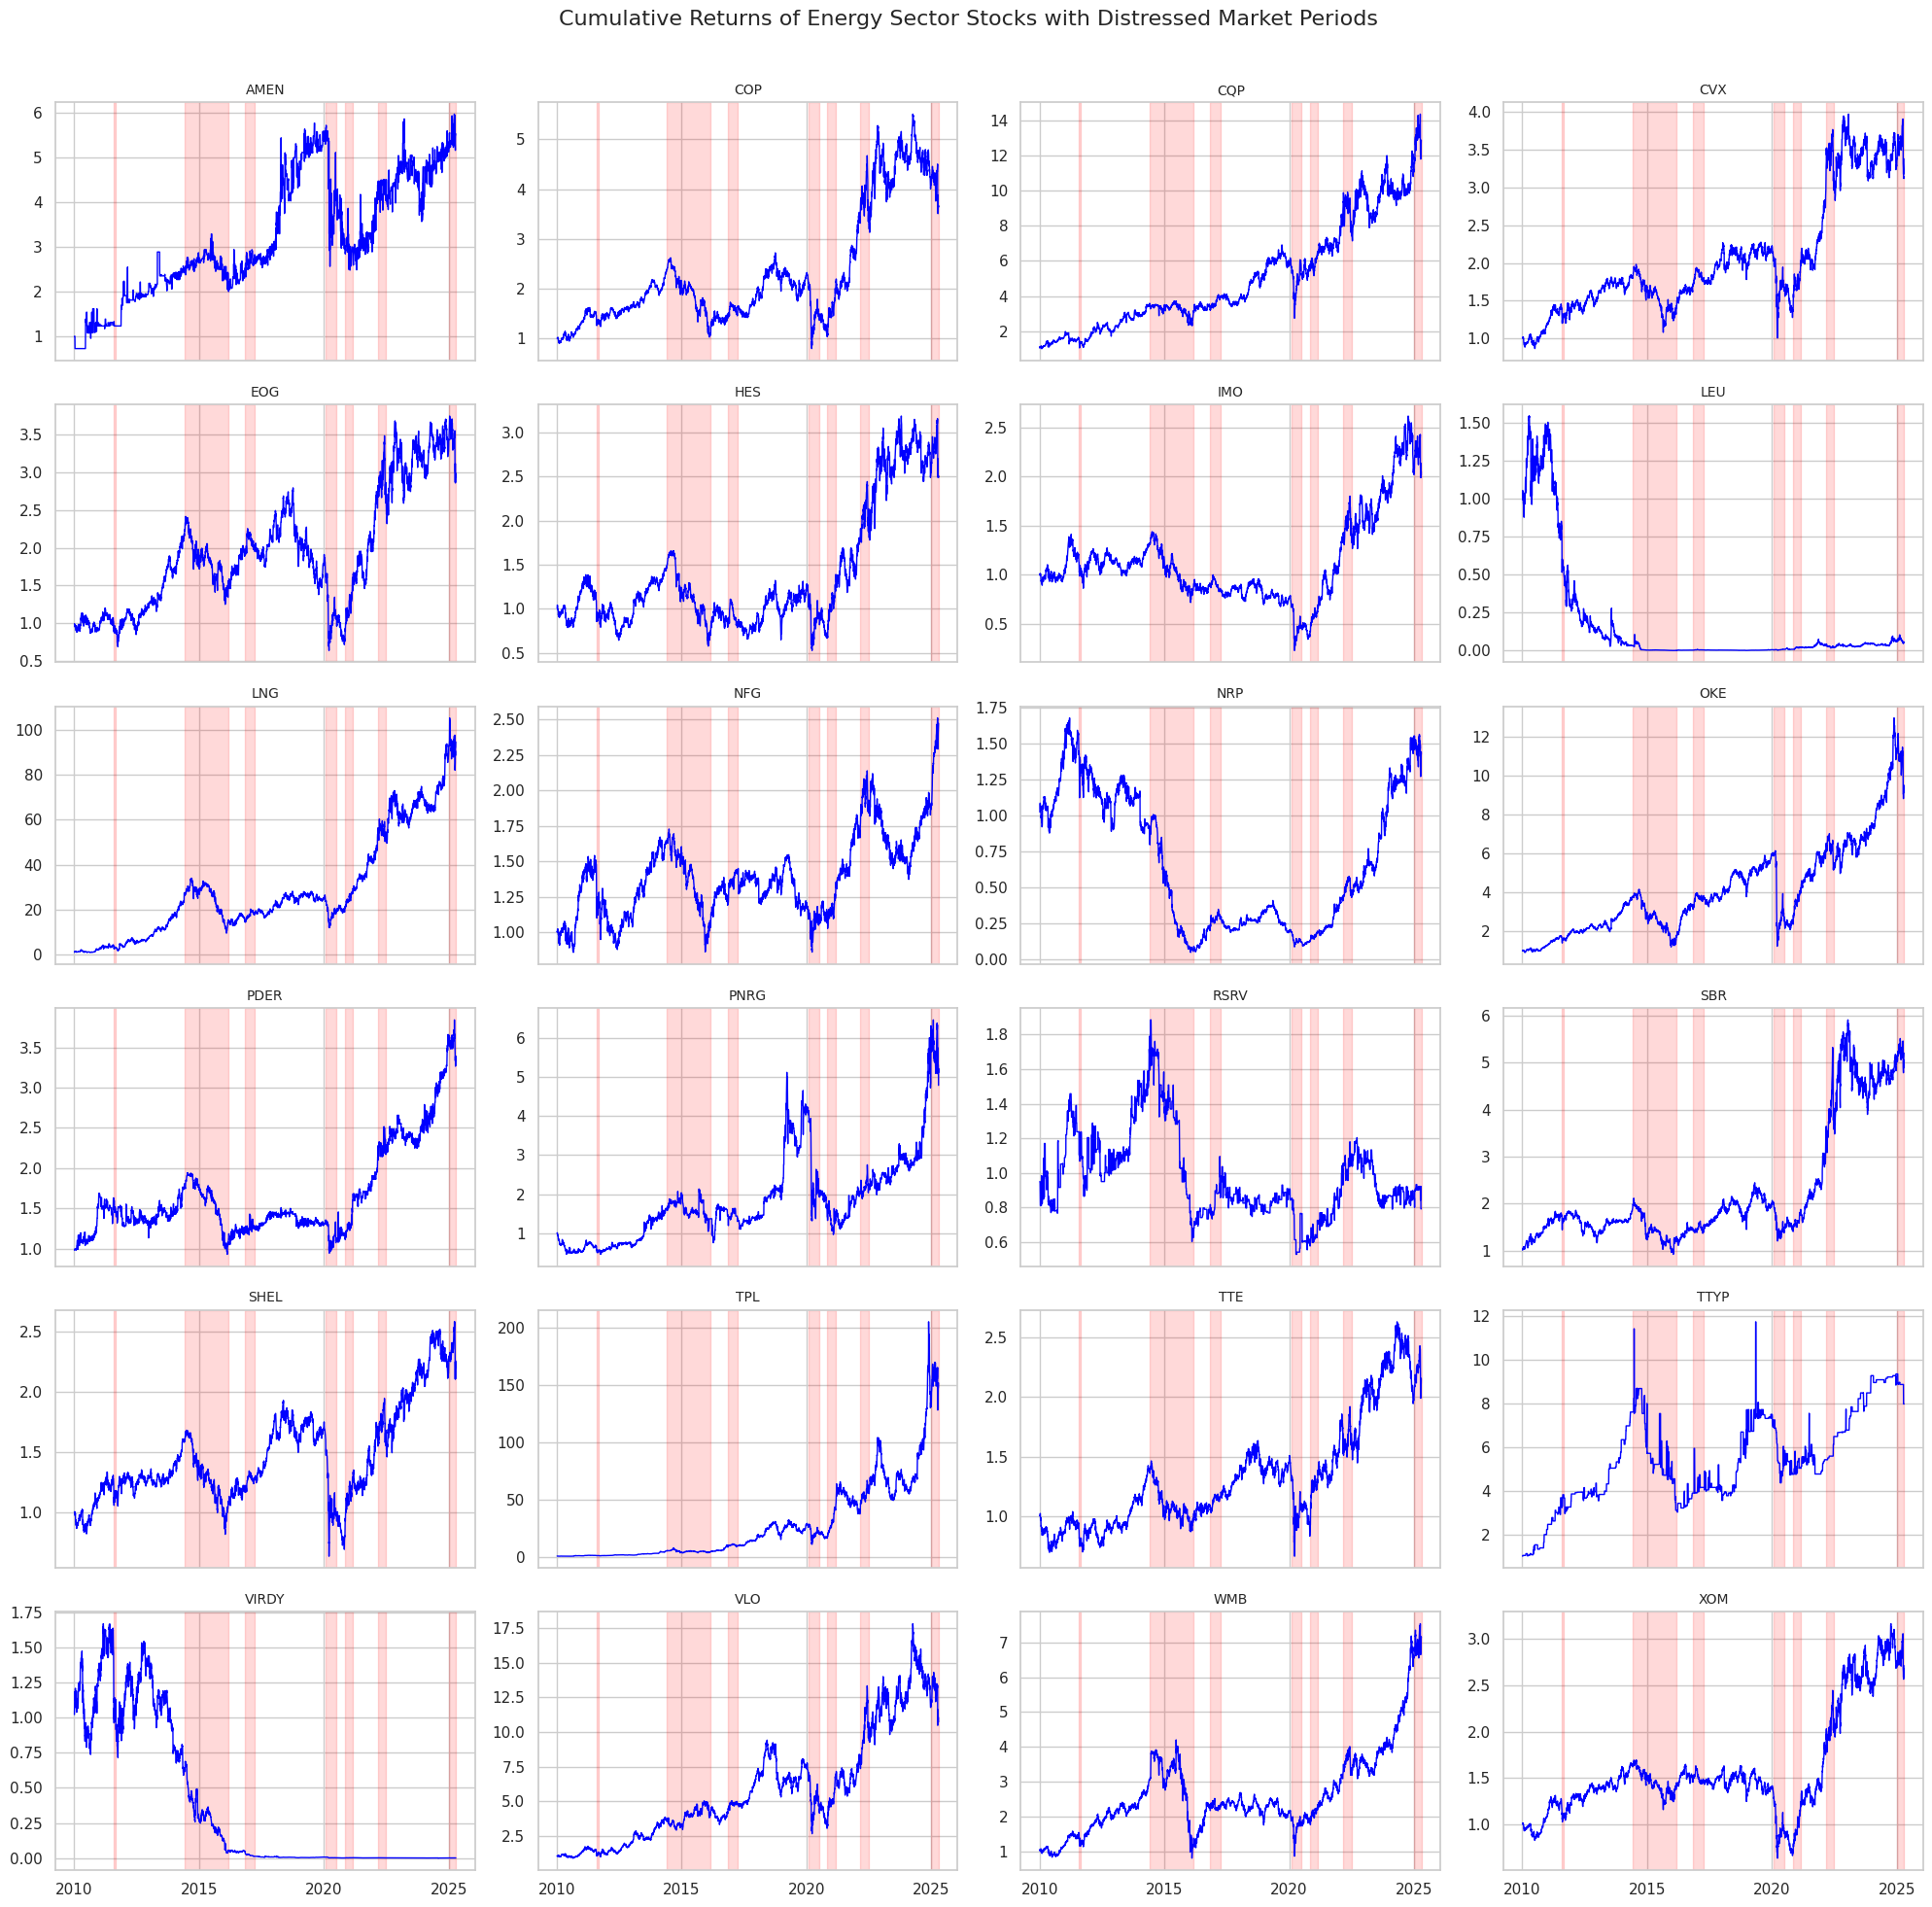

In [ ]:
# Assume cumulative_returns is already defined as (1 + returns).cumprod()
tickers = cumulative_returns.columns.tolist()

# Define distress periods
distressed_periods = [
    ("2011-08-01", "2011-08-31", "Debt Ceiling Crisis"),
    ("2014-06-01", "2016-02-29", "2015 Oil Crash"),
    ("2016-11-01", "2017-03-31", "Trump Transition"),
    ("2020-02-01", "2020-06-30", "COVID-19"),
    ("2020-11-01", "2021-02-28", "Biden Transition"),
    ("2022-03-01", "2022-06-30", "Russia-Ukraine + Sanctions"),
    ("2025-01-01", pd.Timestamp.today().strftime('%Y-%m-%d'), "2025 Tariff War"),
]

# Setup grid dimensions (6 rows x 4 columns = 24 plots per page)
n_rows, n_cols = 6, 4
total_plots = len(tickers)
pages = int(np.ceil(total_plots / (n_rows * n_cols)))

# Plot in pages
for page in range(pages):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20), sharex=True)
    axes = axes.flatten()

    start_idx = page * n_rows * n_cols
    end_idx = min(start_idx + n_rows * n_cols, total_plots)

    for i, idx in enumerate(range(start_idx, end_idx)):
        ticker = tickers[idx]
        ax = axes[i]

        # Plot cumulative return
        ax.plot(cumulative_returns.index, cumulative_returns[ticker], color='blue', linewidth=1)
        ax.set_title(ticker, fontsize=10)
        ax.grid(True)

        # Add shaded distress periods
        for start, end, label in distressed_periods:
            ax.axvspan(pd.to_datetime(start), pd.to_datetime(end), color='red', alpha=0.15)

        # Format x-axis
        ax.xaxis.set_major_locator(mdates.YearLocator(5))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    # Hide any unused subplots
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    plt.suptitle("Cumulative Returns of Energy Sector Stocks with Distressed Market Periods", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()
